In [1]:
%matplotlib inline

import ast

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from matgraphdb.graph.graph_database import MatGraphDB

In [2]:
conn=MatGraphDB()
conn.create_driver()

## Check if graph is loaded into memory

In [3]:
query = """CALL gds.graph.list();
"""

conn.execute_query(query)

[<Record degreeDistribution={'min': 0, 'max': 490, 'p90': 9, 'p999': 206, 'p99': 85, 'p50': 2, 'p75': 4, 'p95': 21, 'mean': 5.683160549173438} graphName='materials_chemenvElements' database='matgraphdb' databaseLocation='local' memoryUsage='59 MiB' sizeInBytes=62405064 nodeCount=17845 relationshipCount=101416 configuration={'relationshipProjection': {'GEOMETRIC_ELECTRIC_CONNECTS': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'weight': {'aggregation': 'DEFAULT', 'property': 'weight', 'defaultValue': None}}, 'type': 'GEOMETRIC_ELECTRIC_CONNECTS'}, 'COMPOSED_OF': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'weight': {'aggregation': 'DEFAULT', 'property': 'weight', 'defaultValue': None}}, 'type': 'COMPOSED_OF'}}, 'readConcurrency': 4, 'relationshipProperties': {}, 'nodeProperties': {}, 'jobId': '6d2c7cac-6f9c-4aa6-be07-aac6f8a81cbf', 'nodeProjection': {'Material': {'label': 'Material', 'prope

## Drop  In-Memory graph

In [ ]:
query = """CALL gds.graph.drop('materials_chemenvElements);

"""

conn.execute_query(query)

## Load graph into memory

In [ ]:
query = """CALL gds.graph.project(
  'materials_chemenvElements',
  ['ChemenvElement','Material'],
  {
    GEOMETRIC_ELECTRIC_CONNECTS: {
      orientation: 'UNDIRECTED',
      properties: 'weight'
    },
    COMPOSED_OF: {
        orientation: 'UNDIRECTED',
        properties: 'weight'
    }
  }
)
"""

conn.execute_query(query)

## Estimate the memory required for embedding algorithm

In [4]:
query = """CALL gds.fastRP.stream.estimate('materials_chemenvElements', {embeddingDimension: 128})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
"""

conn.execute_query(query)

[<Record nodeCount=17845 relationshipCount=101416 bytesMin=29123424 bytesMax=29123424 requiredMemory='27 MiB'>]

## Run the embedding algorithm in stream mode

This does not save the embeddings to In-memory graph or the graph database

In [ ]:
query = """CALL gds.fastRP.stream(
'materials_chemenvElements',
  {
    embeddingDimension: 128,
    randomSeed: 42
  }
)
YIELD nodeId, embedding
"""

conn.execute_query(query)

## Run the embedding algorithm in mutate mode

This saves the embeddings to the In-Memory graph

> **Note:** The specified mutateProperty value must not exist in the projected graph beforehand

In [ ]:
query = """CALL gds.fastRP.mutate(
'materials_chemenvElements',
  {
    embeddingDimension: 128,
    randomSeed: 42,
    mutateProperty: 'fastRP_embedding'
  }
)
YIELD nodeId, embedding
"""

conn.execute_query(query)

## Run the embedding algorithm in write mode

This saves the embedding to the graph database

In [7]:
query = """CALL gds.fastRP.write(
  'materials_chemenvElements',
  {
    embeddingDimension: 128,
    iterationWeights: [0.8, 1, 1, 1],
    randomSeed: 42,
    writeProperty: 'fastrp-embedding'
  }
)
"""

conn.execute_query(query)

[<Record nodeCount=17845 nodePropertiesWritten=17845 preProcessingMillis=0 computeMillis=39 writeMillis=52 configuration={'writeProperty': 'fastrp-embedding', 'randomSeed': 42, 'jobId': 'd2bdf206-55f0-49b2-a4e5-1276197aa5e7', 'propertyRatio': 0.0, 'nodeSelfInfluence': 0, 'sudo': False, 'iterationWeights': [0.8, 1, 1, 1], 'normalizationStrength': 0.0, 'writeConcurrency': 4, 'featureProperties': [], 'logProgress': True, 'nodeLabels': ['*'], 'concurrency': 4, 'relationshipTypes': ['*'], 'embeddingDimension': 128}>]

##  Creating dataset from database 

In [37]:
def create_X_y():
    query = """MATCH (m:Material) RETURN m.name AS id, m.`fastrp-embedding` AS fastrp_embedding, m.band_gap as band_gap, m.formation_energy_per_atom as formation_energy_per_atom, m.composition_reduced as composition_reduced, m.density as density, m.space_group as space_group"""
    results=conn.execute_query(query)
    emb_df = pd.DataFrame([dict(_) for _ in results])
    # return emb_df
    y = emb_df['band_gap'].to_numpy()
    emb_df['X'] = emb_df['fastrp_embedding'].apply(lambda x: np.array(x))
    X = np.array(emb_df['X'].to_list())

    return X, y, emb_df

_,_,df_pre = create_X_y()

df_pre.head()

bandgap_rows = df_pre[(df_pre['band_gap'] >= 5) & (df_pre['band_gap'] <= 6)]
bandgap_rows
for row in bandgap_rows.iterrows():
    print(row[1]['id'], row[1]['composition_reduced'], row[1]['density'], row[1]['space_group'], row[1]['band_gap'])

mp_975 {'S': 1.0, 'F': 6.0} 2.802888788498844 12 5.9124
mp_9816 {'Ge': 1.0, 'F': 4.0} 3.2932293794990457 217 5.500500000000001
mp_985570 {'Si': 1.0, 'O': 2.0} 2.357798378060195 14 5.599
mp_985590 {'Si': 1.0, 'O': 2.0} 2.1220909438472986 58 5.515899999999999
mp_22862 {'Na': 1.0, 'Cl': 1.0} 2.224545043829438 225 5.0037
mp_22904 {'Ca': 1.0, 'Cl': 2.0} 2.1470561707390132 136 5.3533
mp_23193 {'K': 1.0, 'Cl': 1.0} 1.9957638386024725 225 5.027
mp_23199 {'Ba': 1.0, 'Cl': 2.0} 3.8440071249605894 62 5.1132
mp_23209 {'Sr': 1.0, 'Cl': 2.0} 3.0705030511774205 225 5.2286
mp_23210 {'Mg': 1.0, 'Cl': 2.0} 2.274706376094722 166 5.6075
mp_23214 {'Ca': 1.0, 'Cl': 2.0} 2.1614825436196097 58 5.3978
mp_23220 {'Yb': 1.0, 'Cl': 2.0} 5.728042997166286 61 5.5411
mp_24043 {'H': 2.0, 'O': 1.0} 1.3210904831361758 148 5.4391
mp_2414 {'S': 1.0, 'O': 3.0} 2.3366321065151254 33 5.1448
mp_2452 {'P': 2.0, 'O': 5.0} 2.716422359987066 43 5.2021
mp_25469 {'Al': 1.0, 'Cl': 3.0} 2.4064104351605295 12 5.263
mp_10851 {'Si': 1.0

## Splitting dataset

In [22]:
from sklearn.model_selection import train_test_split

X, y,df = create_X_y()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import pandas as pd

# Convert y_train and y_test to pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Get the statistics of y_train
y_train_stats = y_train_series.describe()

# Get the statistics of y_test
y_test_stats = y_test_series.describe()

# Print the statistics
print("Statistics of y_train:")
print(y_train_stats)
print("\nStatistics of y_test:")
print(y_test_stats)

Statistics of y_train:
count    8517.000000
mean        0.549949
std         1.321096
min         0.000000
25%         0.000000
50%         0.000000
75%         0.026800
max         8.375100
dtype: float64

Statistics of y_test:
count    2130.000000
mean        0.589905
std         1.352485
min         0.000000
25%         0.000000
50%         0.000000
75%         0.153850
max         9.335400
dtype: float64


## Training Linear Regression

In [20]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression().fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


import pandas as pd

# Create a dataframe with predicted and test values
df_results = pd.DataFrame({'Predicted': y_pred, 'Test': y_test})

# Display the dataframe
print(df_results)

Mean Squared Error: 0.9228336919216203
R-squared: 0.4952662448624241
      Predicted    Test
0     -0.517522  0.0000
1      0.520192  0.0000
2     -0.068618  0.0000
3     -0.555640  0.7888
4     -0.389969  0.0000
...         ...     ...
2125  -0.319133  0.0000
2126   0.115643  0.0000
2127   0.236624  0.0000
2128   3.943430  5.5162
2129   1.890524  2.7491

[2130 rows x 2 columns]


## Training a Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Assuming X_train and y_train are already defined

# Create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)


In [23]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


import pandas as pd

# Create a dataframe with predicted and test values
df_results = pd.DataFrame({'Predicted': y_pred, 'Test': y_test})

# Display the dataframe
print(df_results)


Mean Squared Error: 0.5544212380977286
R-squared: 0.696765391334609
      Predicted    Test
0      0.089474  0.0000
1      0.021215  0.0000
2      0.173659  0.0000
3      0.436761  0.7888
4      0.059294  0.0000
...         ...     ...
2125   0.000268  0.0000
2126   0.003481  0.0000
2127   0.000000  0.0000
2128   5.609357  5.5162
2129   2.635691  2.7491

[2130 rows x 2 columns]


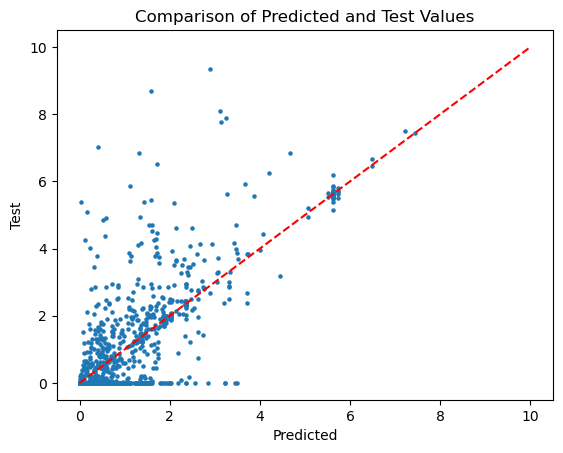

In [30]:
import matplotlib.pyplot as plt

plt.scatter(df_results['Predicted'], df_results['Test'], s=5)  # Change the value of s to adjust the scale of the dots
plt.plot([0, 10], [0, 10], linestyle='dashed', color='red')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Predicted')
plt.ylabel('Test')
plt.title('Comparison of Predicted and Test Values')
plt.show()